# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel, DD03SpeciationModel

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    environment = np.stack([elevation])
    if trait_comp:
        model = DD03SpeciationModel(X, Y, pop_size, birth_rate=1, movement_rate=5, 
                                 slope_trait_env= [0.95],
                                 car_cap_max=250, sigma_env_trait=0.2, 
                                 mut_prob=0.05, sigma_mut=0.05, sigma_mov=5, sigma_comp_trait=0.9, 
                                 sigma_comp_dist=0.1, random_seed=1234)
    else:
        model = IR12SpeciationModel(X, Y, pop_size,nb_radius=50, car_cap=25,
                                 slope_trait_env = [0.95, -0.95],
                                 sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
                                 mut_prob=0.05, random_seed=1234)

    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(environment, [elevation.min()], [elevation.max()], 1)
        dfs.append(model.to_dataframe())
        model.update_individuals(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

## Phylogeny for a speciation model without trait-mediated competition

In [4]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

In [5]:
ind_dtf1

step  time   dt     id           x           y  taxon_id  ancestor_id  \
0         0   0.0  0.0      1  110.251531   15.034664         1            0   
1         0   0.0  0.0      2  152.467702  170.922227         1            0   
2         0   0.0  0.0      3  215.905324  167.809505         1            0   
3         0   0.0  0.0      4  215.939418  152.754495         1            0   
4         0   0.0  0.0      5  168.720328   15.034328         1            0   
...     ...   ...  ...    ...         ...         ...       ...          ...   
16730    99  99.0  0.0  16731  146.994703   31.684154       561          557   
16731    99  99.0  0.0  16732  153.727381    8.753053       561          557   
16732    99  99.0  0.0  16733  149.373203    9.026281       561          557   
16733    99  99.0  0.0  16734  171.486265   16.738785       561          557   
16734    99  99.0  0.0  16735  163.326269  131.813366       561          557   

       n_offspring   fitness   trait_0  
0               24  0.962103  0.500000  
1               22  0.880864  0.500000  
2                3  0.224561  0.500000  
3                3  0.227340  0.500000  
4               18  0.703322  0.500000  
...            ...       ...       ...  
16730            1  0.999673  0.589933  
16731            1  0.995934  0.589933  
16732            1  0.910127  0.676519  
16733            1  0.917312  0.589933  
16734            1  0.862007  0.534236  

[16735 rows x 11 columns]

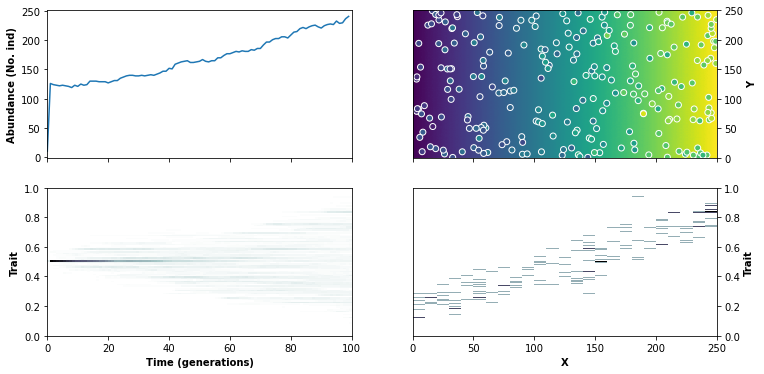

In [6]:
plot_sol(ind_dtf1, elevation1, X1)

In [7]:
taxon_lineage1 = ind_dtf1.ptree.dtf_taxon()
taxon_lineage1

time taxon_id ancestor_id   trait_0  abundance node_type
0     0.0        1           0  0.500000         10      root
1     1.0        2           1  0.500787        126      root
2     2.0        3           2  0.501113        124      root
3     3.0        4           3  0.501944        123      root
4     4.0        5           4  0.502086        122      root
..    ...      ...         ...       ...        ...       ...
569  99.0      570         549  0.846480         13      node
570  99.0      571         550  0.711166         16      node
571  99.0      572         551  0.215365         14      node
572  99.0      573         552  0.486060          5      node
573  99.0      574         553  0.182088          8      node

[574 rows x 6 columns]

In [8]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [9]:
extant1 = ['root'] + taxon_lineage1.groupby(['time']).get_group(taxon_lineage1.time.max()).taxon_id.to_list()
tree1_ex = tree1.extract_tree_with_taxa_labels(extant1)
tree1_ex.print_plot()

                                                            /-------------- 570
                                             /--------------+                  
                                             |              \-------------- 571
/--------------------------------------------+                                 
|                                            |              /-------------- 560
|                                            \--------------+                  
|                                                           \-------------- 561
|                                                                              
|                                            /----------------------------- 567
|                             /--------------+                                 
+                             |              |              /-------------- 569
|                             |              \--------------+                  
|              /--------------+         

In [10]:
tree1_ex.as_string(schema='newick')

'(((:1.0,:1.0)529:405.0,(:78.0,:78.0)388:328.0)250:3249.0,(((:741.0,(:55.0,:55.0)408:686.0)185:970.0,(:253.0,(:21.0,:21.0)461:232.0)301:1458.0)83:1139.0,((:91.0,(:1.0,:1.0)534:90.0)377:1505.0,((:10.0,:10.0)489:810.0,(:45.0,:45.0)419:775.0)173:776.0)91:1254.0)34:805.0)14:449.0;\n'

In [11]:
tree1_ex.max_distance_from_root()

3655.0

## Phylogeny for a speciation model with trait-mediated competition

In [12]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

In [13]:
ind_dtf2

step  time   dt    id           x           y  taxon_id  ancestor_id  \
0        0   0.0  0.0     1  110.251531   15.034664         1            0   
1        0   0.0  0.0     2  152.467702  170.922227         1            0   
2        0   0.0  0.0     3  215.905324  167.809505         1            0   
3        0   0.0  0.0     4  215.939418  152.754495         1            0   
4        0   0.0  0.0     5  168.720328   15.034328         1            0   
...    ...   ...  ...   ...         ...         ...       ...          ...   
8029    99  99.0  1.0  1136  154.584867  229.845438       143          135   
8030    99  99.0  1.0  1137  103.225566  181.692157       141          136   
8031    99  99.0  1.0  1138  136.464333   84.327033       140          138   
8032    99  99.0  1.0  1139  136.125925  229.575927       140          138   
8033    99  99.0  1.0  1140  186.391075   66.936794       141          136   

      n_offspring events_i   death_i   trait_0  
0               1        M  0.071978  0.500000  
1               1        M  0.079846  0.500000  
2               1        M  0.540020  0.500000  
3               1        M  0.550750  0.500000  
4               2        B  0.098603  0.500000  
...           ...      ...       ...       ...  
8029            0        D  0.917388  0.500000  
8030            1        M  1.114898  0.500000  
8031            1        M  0.682746  0.500000  
8032            2        B  0.941348  0.500000  
8033            1        M  0.442593  0.635509  

[8034 rows x 12 columns]

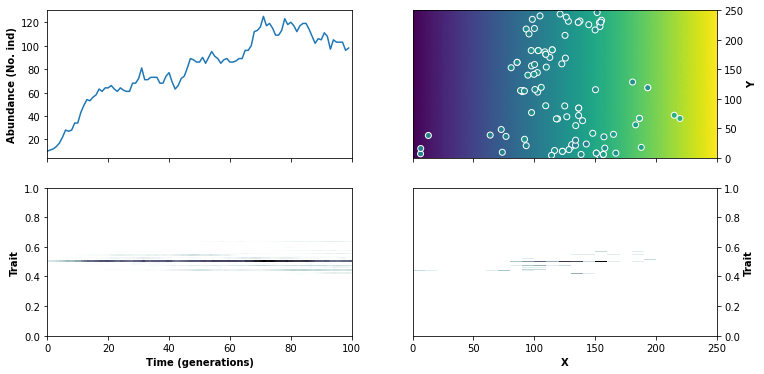

In [14]:
plot_sol(ind_dtf2, elevation2, X2)

In [15]:
taxon_lineage2 = ind_dtf2.ptree.dtf_taxon()
taxon_lineage2

time taxon_id ancestor_id   trait_0  abundance node_type
0     0.0        1           0  0.500000         10      root
1     1.0        2           1  0.500000         11      root
2     2.0        3           2  0.500000         12      root
3     3.0        4           3  0.500000         14      root
4     4.0        5           4  0.500000         17      root
..    ...      ...         ...       ...        ...       ...
138  99.0      139         137  0.486703          2      node
139  99.0      140         138  0.509927         16      node
140  99.0      141         136  0.496389         51      node
141  99.0      142         134  0.487135         14      node
142  99.0      143         135  0.492141         15      node

[143 rows x 6 columns]

In [16]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [17]:
extant2 = ['root'] + taxon_lineage2.groupby(['time']).get_group(taxon_lineage2.time.max()).taxon_id.to_list()
tree2_ex = tree2.extract_tree_with_taxa_labels(extant2)
tree2_ex.print_plot()

/-------------------------------------------------------------------------- 139
+                                                                              
|                 /-------------------------------------------------------- 140
\-----------------+                                                            
                  |                  /------------------------------------- 142
                  \------------------+                                         
                                     |                  /------------------ 143
                                     \------------------+                      
                                                        \------------------ 141
                                                                               
                                                                               


In [18]:
tree2_ex.as_string(schema='newick')

'(:190.0,(:45.0,(:36.0,(:6.0,:6.0)123:30.0)103:9.0)100:145.0)80:3914.0;\n'

In [19]:
tree2_ex.max_distance_from_root()

190.0